In [9]:
from google.colab import drive
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go

from PIL import Image, ImageChops
import os
import random
from scipy.stats import f_oneway, levene, shapiro, kruskal
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from skimage import io, color, transform
from skimage.transform import resize
import shutil
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
import cv2



from sklearn.preprocessing import MinMaxScaler

In [2]:
# Montage de Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Dossiers contenant les images et les masques pour chaque catégorie
image_folders = {
    "COVID": '/content/drive/MyDrive/BC_DS/SAMPLE_COVID-19_Radiography_Dataset/COVID/images',
    "Normal": '/content/drive/MyDrive/BC_DS/SAMPLE_COVID-19_Radiography_Dataset/Normal/images',
    "Lung_Opacity": '/content/drive/MyDrive/BC_DS/SAMPLE_COVID-19_Radiography_Dataset/Lung_Opacity/images',
    "Viral_Pneumonia": '/content/drive/MyDrive/BC_DS/SAMPLE_COVID-19_Radiography_Dataset/Viral_Pneumonia/images'
}

mask_folders = {
    "COVID": '/content/drive/MyDrive/BC_DS/SAMPLE_COVID-19_Radiography_Dataset/COVID/masks',
    "Normal": '/content/drive/MyDrive/BC_DS/SAMPLE_COVID-19_Radiography_Dataset/Normal/masks',
    "Lung_Opacity": '/content/drive/MyDrive/BC_DS/SAMPLE_COVID-19_Radiography_Dataset/Lung_Opacity/masks',
    "Viral_Pneumonia": '/content/drive/MyDrive/BC_DS/SAMPLE_COVID-19_Radiography_Dataset/Viral_Pneumonia/masks'
}

# Nombre d'images à sélectionner par catégorie
images_per_category = 10

# Sélection aléatoire de 10 images de chaque catégorie
selected_image_mask_pairs = []

for category, image_folder_path in image_folders.items():
    mask_folder_path = mask_folders[category]
    image_files = [os.path.join(image_folder_path, file) for file in os.listdir(image_folder_path)]
    mask_files = [os.path.join(mask_folder_path, file) for file in os.listdir(mask_folder_path)]

    # Assurez-vous que les listes sont triées pour que les images et masques correspondent
    image_files.sort()
    mask_files.sort()

    selected_pairs = list(zip(image_files, mask_files))
    selected_image_mask_pairs.extend(selected_pairs)

In [4]:
selected_image_mask_pairs

[('/content/drive/MyDrive/BC_DS/SAMPLE_COVID-19_Radiography_Dataset/COVID/images/COVID-133.png',
  '/content/drive/MyDrive/BC_DS/SAMPLE_COVID-19_Radiography_Dataset/COVID/masks/COVID-133.png'),
 ('/content/drive/MyDrive/BC_DS/SAMPLE_COVID-19_Radiography_Dataset/COVID/images/COVID-1923.png',
  '/content/drive/MyDrive/BC_DS/SAMPLE_COVID-19_Radiography_Dataset/COVID/masks/COVID-1923.png'),
 ('/content/drive/MyDrive/BC_DS/SAMPLE_COVID-19_Radiography_Dataset/COVID/images/COVID-1930.png',
  '/content/drive/MyDrive/BC_DS/SAMPLE_COVID-19_Radiography_Dataset/COVID/masks/COVID-1930.png'),
 ('/content/drive/MyDrive/BC_DS/SAMPLE_COVID-19_Radiography_Dataset/COVID/images/COVID-2018.png',
  '/content/drive/MyDrive/BC_DS/SAMPLE_COVID-19_Radiography_Dataset/COVID/masks/COVID-2018.png'),
 ('/content/drive/MyDrive/BC_DS/SAMPLE_COVID-19_Radiography_Dataset/COVID/images/COVID-2550.png',
  '/content/drive/MyDrive/BC_DS/SAMPLE_COVID-19_Radiography_Dataset/COVID/masks/COVID-2550.png'),
 ('/content/drive/MyDr

In [124]:
class ImagePreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, target_size=(299, 299)):
        self.target_size = target_size

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        preprocessed_images = []
        for image_path, mask_path in X:
            image = cv2.imread(image_path)
            # Redimensionner l'image à la taille cible
            image = cv2.resize(image, self.target_size)
            # Normaliser les valeurs de pixel entre 0 et 1
            image = image / 255.0
            preprocessed_images.append(image)
        return np.array(preprocessed_images)

class MaskPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, target_size=(299, 299), threshold=0.5):
        self.target_size = target_size
        self.threshold = threshold

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        preprocessed_masks = []
        for image_path, mask_path in X:
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            # Redimensionner le masque à la taille cible
            mask_resized = cv2.resize(mask, self.target_size)
            # Convertir le masque en type float32
            mask_resized = mask_resized.astype(np.float32)
            # Répéter le masque sur trois canaux
            mask_resized = np.repeat(mask_resized[:, :, np.newaxis], 3, axis=2)
            preprocessed_masks.append(mask_resized)
        return np.array(preprocessed_masks)




In [125]:
# Créer les pipelines pour les prétraitements d'images et de masques
image_pipeline = Pipeline([
    ('preprocess_image', ImagePreprocessor())
])

mask_pipeline = Pipeline([
    ('preprocess_mask', MaskPreprocessor())
])


In [126]:
transformed_images = image_pipeline.transform(selected_image_mask_pairs)

# Afficher les dimensions de chaque image transformée
for transformed_image in transformed_images:
    print("Dimensions de l'image transformée :", transformed_image.shape)

transformed_masks = mask_pipeline.transform(selected_image_mask_pairs)

# Afficher les dimensions de chaque image transformée
for transformed_mask in transformed_masks:
    print("Dimensions du masque transformée :", transformed_mask.shape)

Dimensions de l'image transformée : (299, 299, 3)
Dimensions de l'image transformée : (299, 299, 3)
Dimensions de l'image transformée : (299, 299, 3)
Dimensions de l'image transformée : (299, 299, 3)
Dimensions de l'image transformée : (299, 299, 3)
Dimensions de l'image transformée : (299, 299, 3)
Dimensions de l'image transformée : (299, 299, 3)
Dimensions de l'image transformée : (299, 299, 3)
Dimensions de l'image transformée : (299, 299, 3)
Dimensions de l'image transformée : (299, 299, 3)
Dimensions de l'image transformée : (299, 299, 3)
Dimensions de l'image transformée : (299, 299, 3)
Dimensions de l'image transformée : (299, 299, 3)
Dimensions de l'image transformée : (299, 299, 3)
Dimensions de l'image transformée : (299, 299, 3)
Dimensions de l'image transformée : (299, 299, 3)
Dimensions de l'image transformée : (299, 299, 3)
Dimensions de l'image transformée : (299, 299, 3)
Dimensions de l'image transformée : (299, 299, 3)
Dimensions de l'image transformée : (299, 299, 3)


In [127]:
# Créer le pipeline final
final_pipeline = FeatureUnion([
    ('image_pipeline', image_pipeline),
    ('mask_pipeline', mask_pipeline)
])

In [370]:
class ImageMaskPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, target_size=(299, 299), threshold=0.5):
        self.target_size = target_size
        self.threshold = threshold

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        preprocessed_images = []
        preprocessed_masks = []
        for image_path in X:
            # Charger l'image
            image = cv2.imread(image_path)
            # Redimensionner l'image à la taille cible
            image = cv2.resize(image, self.target_size)
            # Convertir les valeurs de pixel en flottants et normaliser entre 0 et 1
            image = image.astype(np.float32) / 255.0
            preprocessed_images.append(image)


            # Extraire le chemin du masque en remplaçant "_image" par "_mask"
            mask_path = image_path.replace("_image", "_mask")
            # Charger le masque en couleur (RGB)
            mask = cv2.imread(mask_path)
            # Convertir en échelle de gris
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
            # Redimensionner le masque à la taille cible
            mask = cv2.resize(mask, self.target_size)
            # Binariser le masque
            _, mask = cv2.threshold(mask, self.threshold * 255, 255, cv2.THRESH_BINARY)
            # Convertir les valeurs de pixel en flottants et normaliser entre 0 et 1
            mask = mask.astype(np.float32) / 255.0
            # Répéter le masque sur trois canaux
            mask = np.repeat(mask[..., np.newaxis], 3, axis=2)
            preprocessed_masks.append(mask)

        return np.array(preprocessed_images), np.array(preprocessed_masks)

# Créer le pipeline
image_mask_pipeline = Pipeline([
    ('preprocess_image_mask', ImageMaskPreprocessor())
])

# Appliquer le pipeline sur les chemins d'images
preprocessed_images, preprocessed_masks = image_mask_pipeline.transform(image_paths)





In [371]:
print(preprocessed_images[0].shape)
print(preprocessed_masks[0].shape)

(299, 299, 3)
(299, 299, 3)


In [372]:


# Extract the ROI using cv2.bitwise_and()
roi =preprocessed_images[0]*preprocessed_masks[0]

# Display the extracted ROI
cv2.imshow("ROI", roi)
cv2.waitKey(0)
cv2.destroyAllWindows()

DisabledFunctionError: cv2.imshow() is disabled in Colab, because it causes Jupyter sessions
to crash; see https://github.com/jupyter/notebook/issues/3935.
As a substitution, consider using
  from google.colab.patches import cv2_imshow


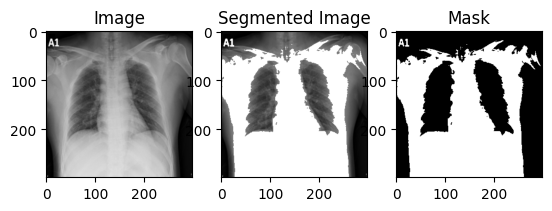

In [317]:
# Afficher les images segmentées
for i in range(0, 1):
    segmented_image = preprocessed_masks[i] * preprocessed_images[i]
    plt.subplot(1, 3, 1)
    plt.imshow(preprocessed_images[i],cmap='gray')
    plt.title('Image')

    plt.subplot(1, 3, 2)
    plt.imshow(segmented_image, cmap='gray')
    plt.title('Segmented Image')

    plt.subplot(1, 3, 3)
    plt.imshow(preprocessed_masks[i])
    plt.title('Mask')

    plt.show()

In [367]:
class ImageMaskProcessor(BaseEstimator, TransformerMixin):
    def __init__(self, image_size=(299, 299), mask_size=(256, 256)):
        self.image_size = image_size
        self.mask_size = mask_size

    def fit(self, X, y=None):
        return self

    def transform(self, selected_image_mask_pairs):
        preprocessed_images = []
        preprocessed_masks = []

        for image_path, mask_path in selected_image_mask_pairs:
            # Charger l'image en niveaux de gris
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            # Redimensionner l'image à la taille spécifiée
            image = cv2.resize(image, self.image_size)
            # Normaliser les valeurs de pixel entre 0 et 1
            image = image.astype(np.float32) / 255.0
            preprocessed_images.append(image)

            # Charger le masque en couleur (RGB)
            mask = cv2.imread(mask_path)
            # Convertir le masque en échelle de gris
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
            # Redimensionner le masque à la taille spécifiée
            mask = cv2.resize(mask, self.mask_size)
            # Binariser le masque
            _, mask = cv2.threshold(mask, 128, 255, cv2.THRESH_BINARY)
            # Normaliser les valeurs de pixel entre 0 et 1
            mask = mask.astype(np.float32) / 255.0
            preprocessed_masks.append(mask)

        return np.array(preprocessed_images), np.array(preprocessed_masks)

In [368]:
image_mask_processor_pipeline = Pipeline([
    ('process_images_masks', ImageMaskProcessor())
])

preprocessed_images, preprocessed_masks = image_mask_processor_pipeline.transform(selected_image_mask_pairs)

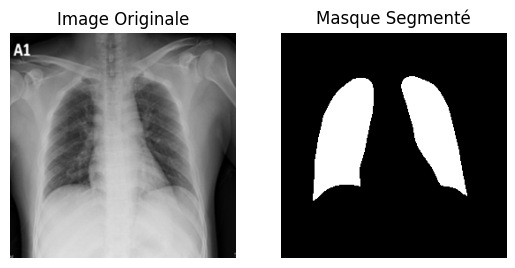

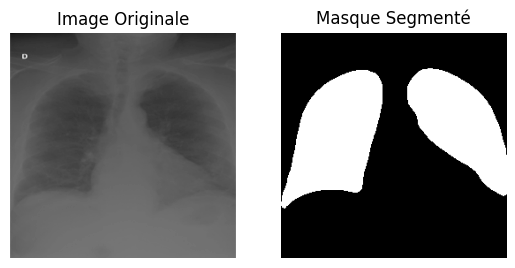

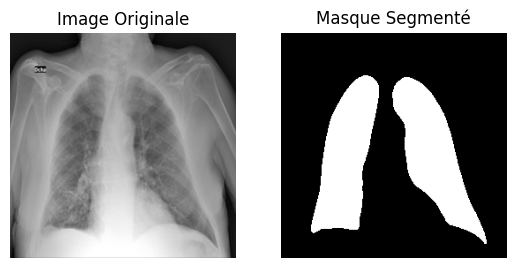

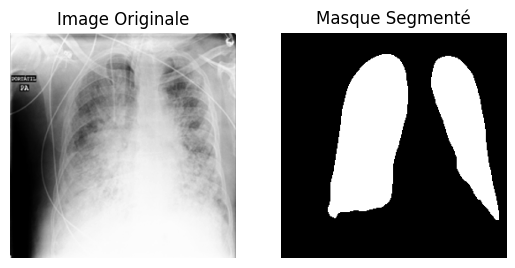

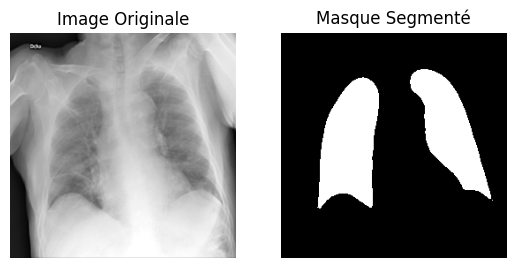

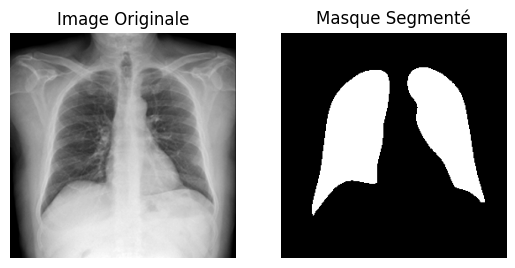

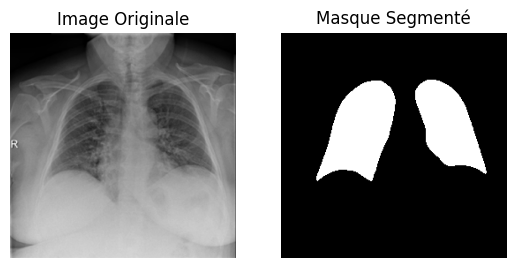

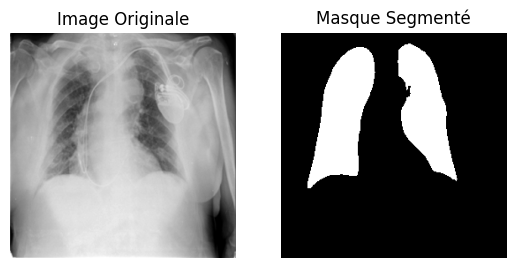

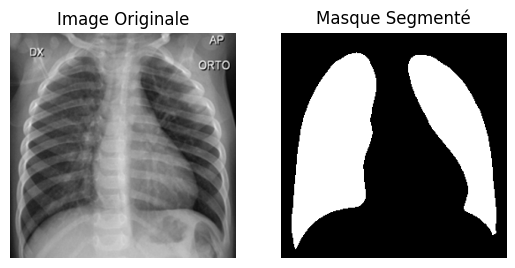

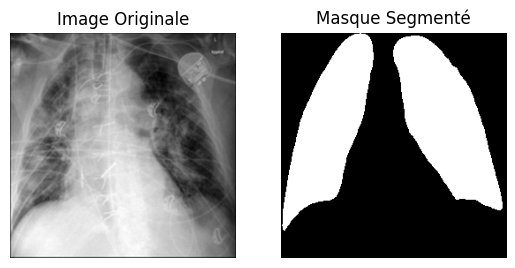

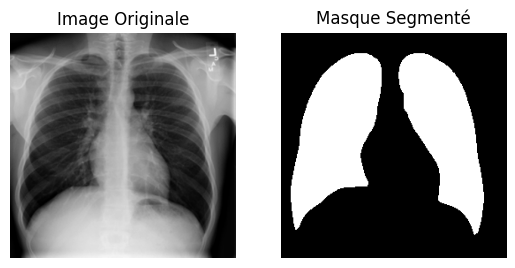

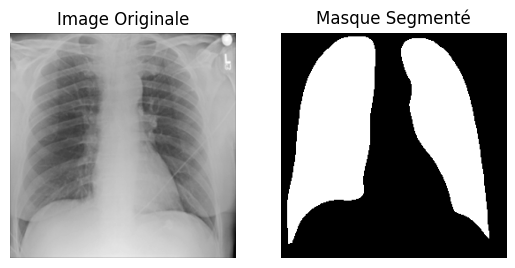

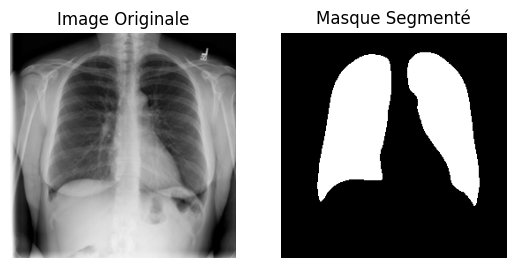

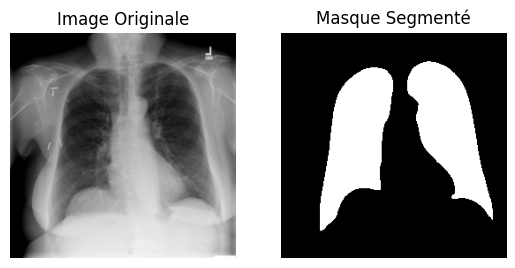

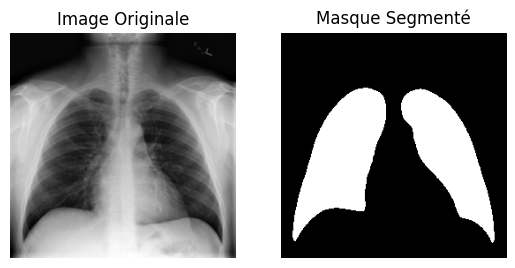

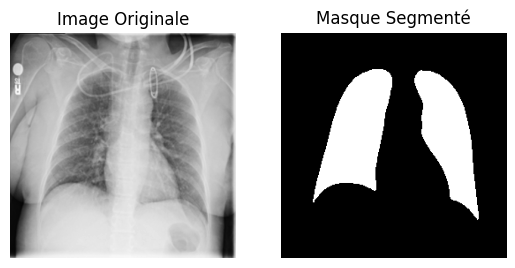

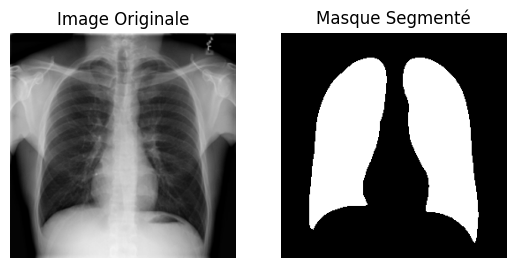

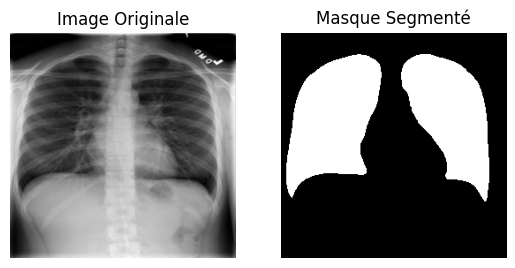

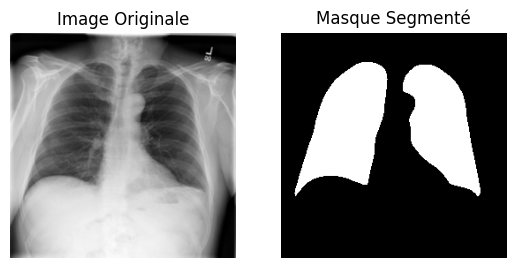

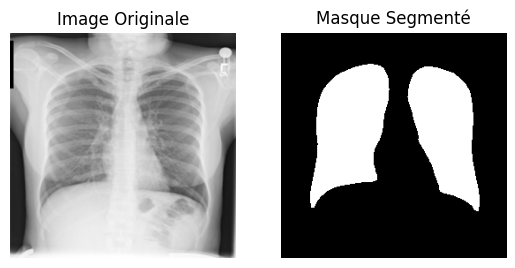

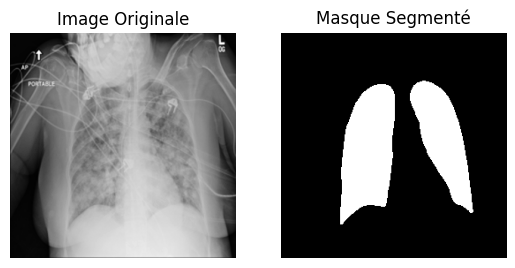

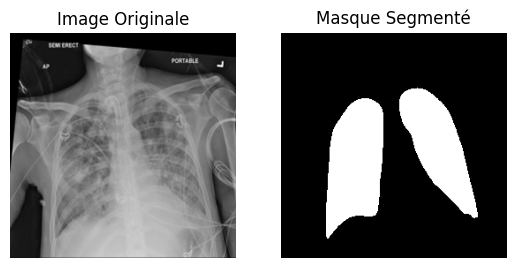

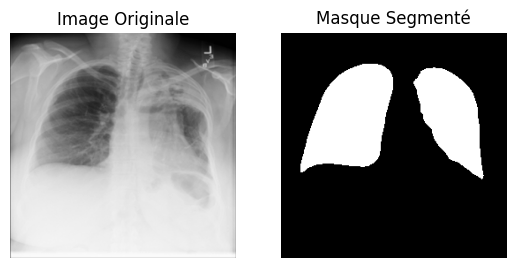

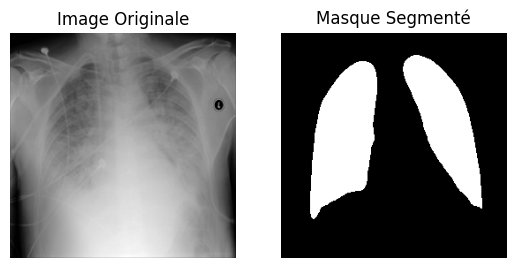

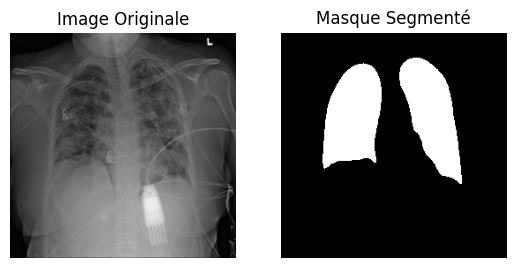

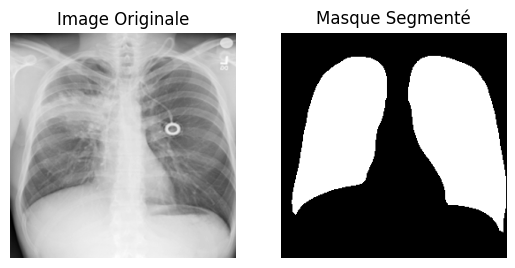

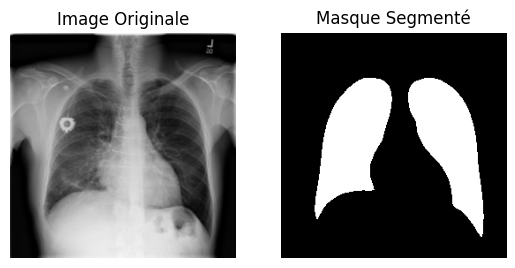

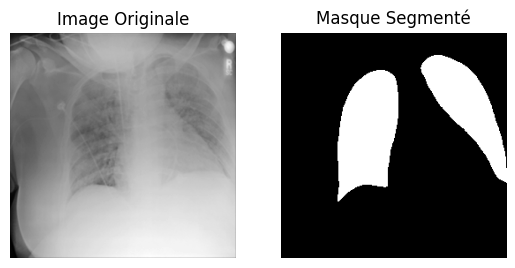

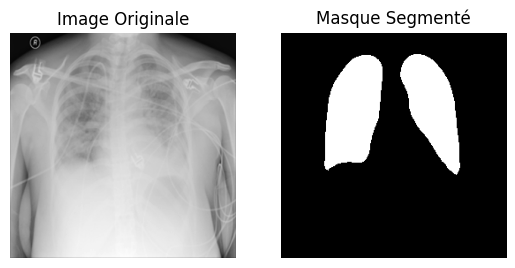

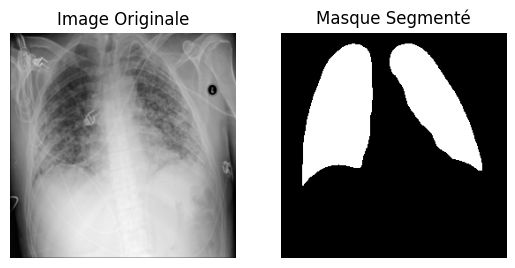

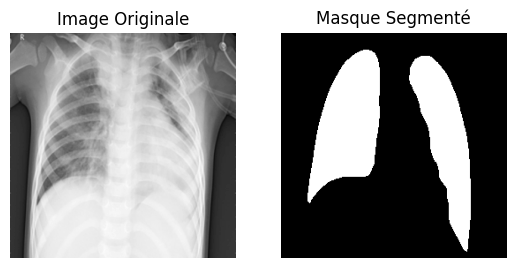

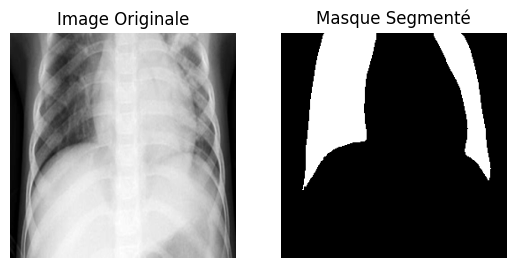

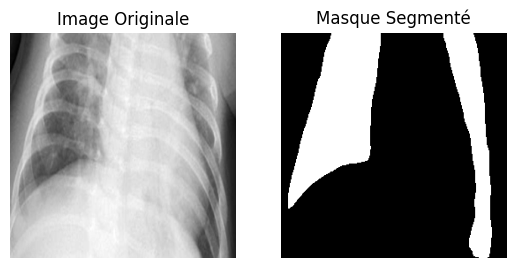

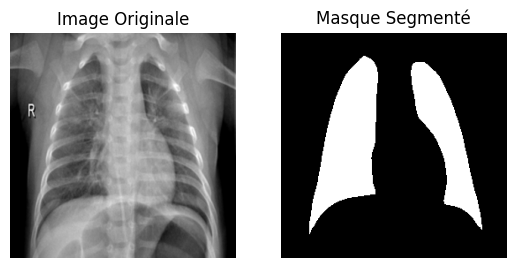

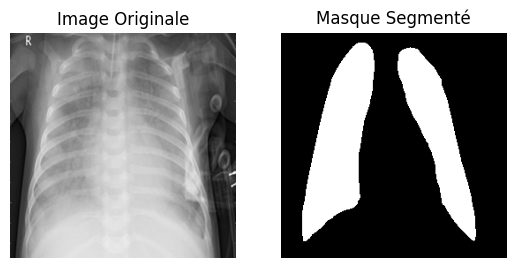

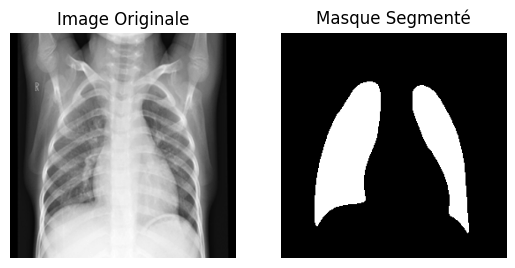

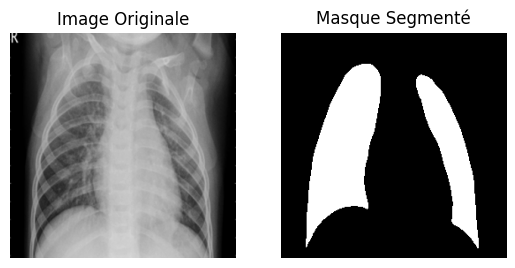

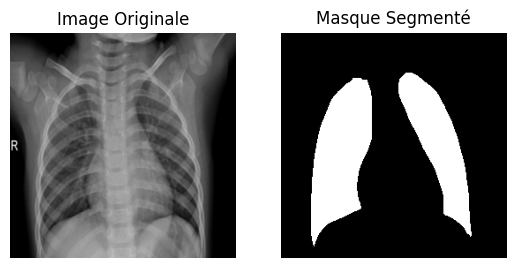

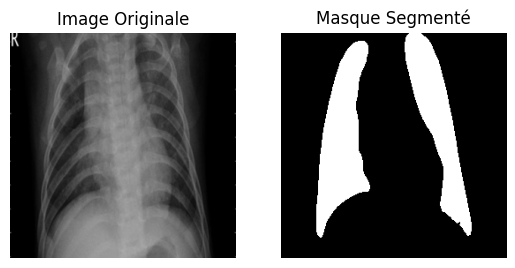

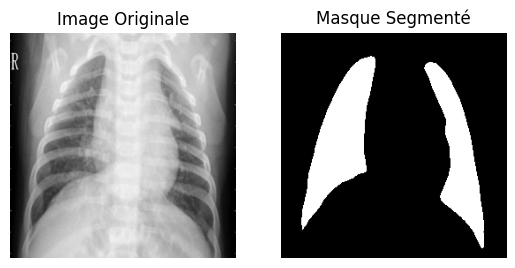

In [364]:
for i in range(len(preprocessed_images)):
    # Afficher l'image originale
    plt.subplot(1, 2, 1)
    plt.imshow(preprocessed_images[i], cmap='gray')
    plt.title('Image Originale')
    plt.axis('off')

    # Afficher le masque segmenté
    plt.subplot(1, 2, 2)
    plt.imshow(preprocessed_masks[i], cmap='gray')
    plt.title('Masque Segmenté')
    plt.axis('off')

    plt.show()

In [376]:
class ImageMaskProcessor(BaseEstimator, TransformerMixin):
    def __init__(self, target_size=(299, 299)):
        self.target_size = target_size

    def fit(self, X, y=None):
        return self

    def transform(self, selected_image_mask_pairs):
        preprocessed_images = []
        preprocessed_masks = []

        for image_path, mask_path in selected_image_mask_pairs:
            # Charger l'image en niveaux de gris
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            # Redimensionner l'image à la taille spécifiée
            image = cv2.resize(image, self.target_size)
            # Normaliser les valeurs de pixel entre 0 et 1
            image = image.astype(np.float32) / 255.0
            # Ajouter un canal pour obtenir une forme (299, 299, 1)
            image = np.expand_dims(image, axis=-1)
            preprocessed_images.append(image)

            # Charger le masque en couleur (RGB)
            mask = cv2.imread(mask_path)
            # Redimensionner le masque à la taille spécifiée
            mask = cv2.resize(mask, self.target_size)
            # Convertir le masque en niveaux de gris
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
            # Normaliser les valeurs de pixel entre 0 et 1
            mask = mask.astype(np.float32) / 255.0
            # Ajouter un canal pour obtenir une forme (299, 299, 1)
            mask = np.expand_dims(mask, axis=-1)
            # Répéter le masque sur trois canaux pour correspondre aux images
            mask = np.repeat(mask, 3, axis=-1)
            preprocessed_masks.append(mask)

        return np.array(preprocessed_images), np.array(preprocessed_masks)

In [377]:
image_mask_processor_pipeline = Pipeline([
    ('process_images_masks', ImageMaskProcessor())
])

preprocessed_images, preprocessed_masks = image_mask_processor_pipeline.transform(selected_image_mask_pairs)

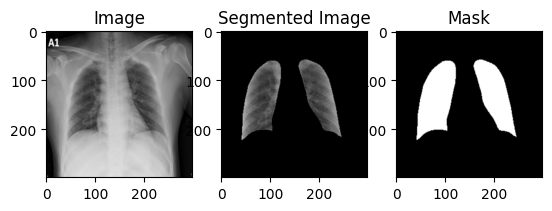

In [378]:
# Afficher les images segmentées
for i in range(0, 1):
    segmented_image = preprocessed_masks[i] * preprocessed_images[i]
    plt.subplot(1, 3, 1)
    plt.imshow(preprocessed_images[i],cmap='gray')
    plt.title('Image')

    plt.subplot(1, 3, 2)
    plt.imshow(segmented_image, cmap='gray')
    plt.title('Segmented Image')

    plt.subplot(1, 3, 3)
    plt.imshow(preprocessed_masks[i])
    plt.title('Mask')

    plt.show()